We'll be playing around a little bit more with the *Super Smash Bros. Melee* dataset.  Last time, I promise.  The dataset has been altered to have a larger sample size.  This data generation was intentionally done to lean into logistic regression.

We want to predict the outcome variable `won`; this column takes the values `1` or `0`.  A `1` indicates that the player in the row won the set; a `0` indicates that the player lost.

Review questions:
* What are the two major classes of machine learning problems? What type is this one?
* The correct answer to the first question has two major subclasses of machine learning problems, what are they?  Which of the two groups would you put our SSBM task into?

In [26]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [27]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


data_url = "https://raw.githubusercontent.com/AdamSpannbauer/twitch_chat/master/data/slippi_data/generated_ssbm.csv"
ssbm = pd.read_csv(data_url).drop(columns=["index"])
ssbm.head()

,gamerTag,numCombosStarted,totalComboDamage,averageComboDamage,maxComboDamage,percentTimeClosestCenter,percentTimeInShield,rollCount,numRecoveries,totalRecoveryDamage,...,numEdgeguards,numFailedEdgeguards,edgeguardSuccessPercent,numPunishesStarted,numKillingPunishes,totalPunishDamage,averagePunishDamage,neutralWinPercent,openingsPerKill,won
0,S2J,79.0,1119.17,14.166709,37.92,53.205737,7.801918,43.0,23.0,375.85,...,24.0,23.0,4.166667,66.0,9.0,1124.17,17.032879,45.833333,7.333333,0.0
1,Hungrybox,101.0,1724.49,17.074158,89.08,46.794263,3.151007,7.0,24.0,94.10,...,23.0,11.0,52.173913,78.0,15.0,1724.49,22.108846,54.166667,5.200000,1.0
2,Leffen,74.0,1226.34,16.572162,66.09,53.446289,3.783666,13.0,20.0,269.00,...,22.0,13.0,40.909091,50.0,11.0,1229.34,24.586800,53.763441,4.545455,1.0
3,PewPewU,60.0,912.56,15.209333,66.24,46.553711,1.933133,4.0,22.0,240.41,...,20.0,15.0,25.000000,43.0,6.0,913.56,21.245581,46.236559,7.166667,0.0
4,Infinite Numbers,53.0,932.94,17.602642,140.80,51.024071,8.328259,9.0,26.0,499.92,...,14.0,13.0,7.142857,45.0,5.0,932.94,20.732000,39.473684,9.000000,0.0


<IPython.core.display.Javascript object>

Let's say we've already done our EDA and want to get straight into modeling.  How might we start down this road?

A good place to start could be to plit up our data into it's `X` and `y` components and then doing a train test split.  Our target variable is `won` so we'll call it `y`; the rest of the features we'll call `X`.  We'll also drop the `gamerTag` variable since it's more of an ID.

In [29]:
X = ssbm.drop(columns=["gamerTag", "won"])
y = ssbm["won"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    # We went to the moon in...
    random_state=1969,
)

print(f"n train records: {X_train.shape[0]}")
print(f"n test records: {X_test.shape[0]}")

n train records: 844
n test records: 212


<IPython.core.display.Javascript object>

Let's say we only want to move forward with the 2 best predictors of our output variable `won`.  How might we do that?

We could use `SelectKBest` from `sklearn.feature_selection`.  We want to use the `f_classif` method to run ANOVAs.  We do this because our features are continuous and our target is categorical.

In [30]:
# Storing columns since we're going to overwrite
# X with a numpy array (which will delete its column names)
cols = X_train.columns

# Perform ANOVAs for each of our features and outcome
selector = SelectKBest(f_classif, k=2)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)

# We don't have to transform this back into a dataframe
# this is just being done for better display
selected_cols = cols[selector.get_support()]
X_train = pd.DataFrame(X_train, columns=selected_cols, index=y_train.index)
X_train.head()

,numKillingPunishes,openingsPerKill
827,12.308586,4.824103
111,11.601353,7.256473
263,9.696096,8.428894
377,9.151511,9.183810
396,8.745586,6.038657


<IPython.core.display.Javascript object>

Let's visualize our remaining 2 features with our target variable.  How do we want to do this?

Maybe boxplots?

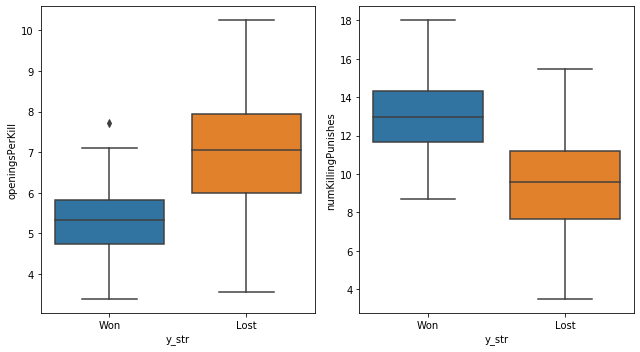

<IPython.core.display.Javascript object>

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

y_str = y_train.map({0: "Lost", 1: "Won"})
plot_df = X_train.copy()
plot_df["y_str"] = y_str

sns.boxplot("y_str", "openingsPerKill", data=plot_df, ax=axes[0])
sns.boxplot("y_str", "numKillingPunishes", data=plot_df, ax=axes[1])

fig.tight_layout()
plt.show()

Maybe a scatterplot?

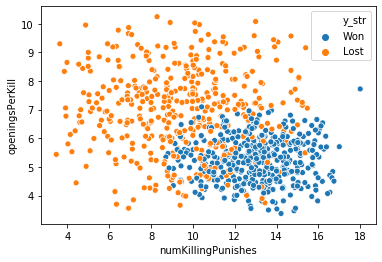

<IPython.core.display.Javascript object>

In [7]:
sns.scatterplot("numKillingPunishes", "openingsPerKill", hue="y_str", data=plot_df)
plt.show()

Now let's build a `LogisticRegression` model and score it on our train and test data.

But first! Let's look at what logistic regression is doing.  If we were to just use one of our columns to predict who won, we might look at a scatter plot of that column with the target variable.

In doing so, we see a pattern.  In general, the higher the `numKillingPunishes`, the more likely a player is to win.  But how could we draw a line to predict the probability of someone winning based on this info?

The trick is that the line doesn't have to be straight.

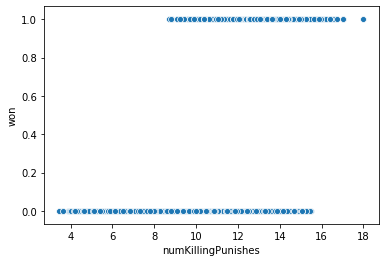

<IPython.core.display.Javascript object>

In [8]:
sns.scatterplot("numKillingPunishes", "won", data=ssbm)
plt.show()

We'll talk about the below code in a couple cells, for now, just now we're using a logisitic regression model to draw some lines on the scatter plot from before.

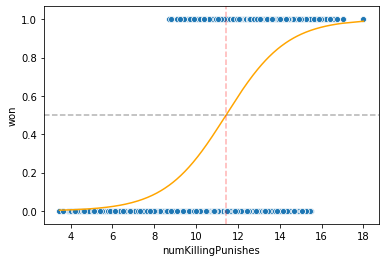

<IPython.core.display.Javascript object>

In [9]:
model = LogisticRegression()
model.fit(X_train[["numKillingPunishes"]], y_train)

pred_df = model.predict_proba(X_train[["numKillingPunishes"]])
pred_df = pd.DataFrame(pred_df, columns=["prob_lose", "prob_win"])
pred_df["numKillingPunishes"] = X_train["numKillingPunishes"].reset_index(drop=True)
pred_df = pred_df.sort_values("numKillingPunishes")

sns.scatterplot("numKillingPunishes", "won", data=ssbm)
plt.plot(pred_df["numKillingPunishes"], pred_df["prob_win"], c="orange")
plt.axhline(0.5, c="black", ls="--", alpha=0.3)
plt.axvline(11.42896875, c="red", ls="--", alpha=0.3)
plt.show()

But we want to predict with more than just one variable! What does that look like?

In [14]:
px.scatter_3d(ssbm, "numKillingPunishes", "openingsPerKill", "won")

<IPython.core.display.Javascript object>

We'll talk about the below code in a couple cells, for now, just now we're using a logisitic regression model to draw some lines on the scatter plot from before.

In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)

pred_df = model.predict_proba(X_train)
pred_df = pd.DataFrame(pred_df[:, 1], columns=["prob_win"])
pred_df["numKillingPunishes"] = X_train["numKillingPunishes"].reset_index(drop=True)
pred_df["openingsPerKill"] = X_train["openingsPerKill"].reset_index(drop=True)
pred_df["won"] = y_train.reset_index(drop=True)
pred_df = pd.melt(
    pred_df, id_vars=["numKillingPunishes", "openingsPerKill"], var_name="won"
)
pred_df.loc[pred_df["won"] == "prob_win", "won"] = "predicted"
pred_df.loc[pred_df["won"] == "won", "won"] = "actual"

px.scatter_3d(pred_df, "numKillingPunishes", "openingsPerKill", "value", color="won")

<IPython.core.display.Javascript object>

Alright, now to talk about actually fitting the model.

* Define a `LogisticRegression` model and `fit` it to the training data

In [36]:
# google: sklearn logistic regression
# top result says: sklearn.linear_model.LogisticRegression
# resulting import statement:
# from sklearn.linear_model import LogisticRegression

# model = ModelName()
# model.fit(X_train, y_train)

# General model building/evaluating process 
# (points 1-6a is for everything we're going to do; 6b is just for classification)
# 1. choose/define model
#    a. `model = ModelName()`
# 2. fit to train data
#    a. `model.fit(X_train, y_train)`
# 3. score on train
#    a. `model.score(X_train, y_train)`
# 4. score on test
#    a. `model.score(X_test, y_test)`
# 5. assess these scores for overfitting
# 6. How are you making mistakes, accuracy is a bad metric in a vaccuum
#    a. `y_pred = model.predict(X_test)`
#    b. sklearn.metrics.confustion_matrix
#       * confustion_matrix(y_true=y_test, y_pred=y_pred)

# For us today:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

* `score` the model on the training data

In [22]:
train_score = model.score(X_train, y_train)
print(f"train score: {train_score}")

0.8518957345971564

<IPython.core.display.Javascript object>

* `score` the model on the testing data

In [23]:
test_score = model.score(X_test, y_test)
print(f"test score: {test_score}")

ValueError: X has 22 features per sample; expecting 2

<IPython.core.display.Javascript object>

We get an error saying `X has 22 features per sample; expecting 2`.  Remember, we applied `SelectKBest` to our training data.  We need to do the same to whatever data we want to deploy are model onto.  We can do that with the `.transform()` method of our `SelectKBest` instance that we named `selector` as shown below.

* `transform` the testing data using the `SelectKBest` instance from before
* `score` the newly transformed test data

In [33]:
# X_test = selector.transform(X_test)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"train score: {train_score}")
print(f"test score: {test_score}")

train score: 0.8518957345971564
test score: 0.8679245283018868


<IPython.core.display.Javascript object>

Let's make some predictions, and see where our model is making mistakes.  How would we go about this?

In [37]:
model.predict(X_test)

array([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1.])

<IPython.core.display.Javascript object>

In [43]:
pred_cutoff = 0.8

probs = model.predict_proba(X_test)
probs_df = pd.DataFrame(probs, columns=["prob_of_0", "prob_of_1"])
# probs_df["sum_of_prob"] = probs_df["prob_of_0"] + probs_df["prob_of_1"]
probs_df["custom_threshold_pred_label"] = probs_df["prob_of_1"] > pred_cutoff

probs_df.head()

,prob_of_0,prob_of_1,custom_threshold_pred_label
0,0.142394,0.857606,True
1,0.947995,0.052005,False
2,0.164993,0.835007,True
3,0.998306,0.001694,False
4,0.255510,0.744490,False


<IPython.core.display.Javascript object>

In [44]:
y_pred = model.predict(X_test)

confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# We could put this in dataframe with row/column
# labels to make it easier to read
confusion_df = pd.DataFrame(
    confusion_mat,
    columns=["predicted_0", "predicted_1"],
    index=["actual_0", "actual_1"],
)
confusion_df

,predicted_0,predicted_1
actual_0,85,17
actual_1,11,99


<IPython.core.display.Javascript object>

We might want to visualize our mistakes.  To do this we might put our data back into a dataframe.  Add a column indicating `True` or `False` when we made an error in prediction.

In [ ]:
diagnostic_df = pd.DataFrame(X_test, columns=X_train.columns)
diagnostic_df['won'] = y_test.values
diagnostic_df['won_pred'] = y_pred
diagnostic_df['error'] = diagnostic_df['won'] != diagnostic_df['won_pred']
diagnostic_df.head()

We can then use `seaborn` like before, but this time we can include a notion of the errors made.

In [ ]:
sns.scatterplot('numKillingPunishes', 
                'openingsPerKill', 
                hue='won',
                style='error',
                data=diagnostic_df)
plt.show()

If we wanted to be more formal about seeing the decision boundary we could plot using `plot_decision_regions` from `mlextend`.

In [ ]:
# This wants an array that's not the float type
labels = y_test.values.astype(int)

plot_decision_regions(X_test, labels, clf=model)
plt.show()

So what is actually happening when making predictions.

In [ ]:
coef_1 = model.coef_[0, 0]
coef_2 = model.coef_[0, 1]
intercept = model.intercept_[0]

print(f'log(odds) = {intercept:.2f} + {coef_1:.2f}*X1 + {coef_2:.2f}*X2')

Above shows how we can 'write' the formula that our logistic regression model learned from our data.  Seems pretty easy to apply, all we're missing is is some intuition of what the `log(odds)` is doing.  Let's see how we could make a prediction by 'hand' with a single observation.

First we'll subset out a single observation, we'll call it `obs`.

In [ ]:
obs = ssbm.loc[[0], ['numKillingPunishes', 'openingsPerKill']]
obs

Now we can fill out the right hand side of the equation and do the math to calculate the value of this `log(odds)` thing.

In [ ]:
X1 = obs['numKillingPunishes']
X2 = obs['openingsPerKill']

log_odds = intercept + coef_1 * X1 + coef_2 * X2
# Some manipulation to get to just a number from log_odds (which is a pandas.Series)
log_odds = log_odds.values[0]
log_odds

Like it sounds, log(odds) is the log of the odds.  So, to go from log(odds) to odds we need to do $e^{log(odds)}$.  This is because, raising $e$ to x is the inverse of taking the log of x (like how multiplying by x is the inverse of dividing by x).  

In [ ]:
odds = np.exp(log_odds)
odds

Now we have the odds as 0.0269.  This number doesn't mean much to me; I'd much prefer probability instead of odds. If you're familiar with gambling terms you be comfortable with this number.

If we did want to convert to probability we can do the following: $\frac{odds}{1 + odds}$.  For example, saying "5 to 1 odds" ($\frac{5}{1}$) is the same as saying a probability of $\frac{5}{6}$ or $0.833$.

In [ ]:
prob = odds / (1 + odds)

# Formula can be re-written to match the slides
# prob = 1 / (1 + np.exp(-log_odds))

print(f'Probability of losing: {1 - prob:.4f}')
print(f'Probability of winning: {prob:.4f}')

Our results show that our observation only as a 2.6% chance of winning.  If we wanted to compare this result to what our model would predict, we could use its `predict_proba` method.  This method outputs a probability for each class.

In [ ]:
prob_of_loss, prob_of_win = model.predict_proba(obs)[0]
print(f'Probability of losing: {prob_of_loss:.4f}')
print(f'Probability of winning: {prob_of_win:.4f}')

Using our coefficients and some math, we were able to mimic our `sklearn` model.  But what do these coefficients actually mean?

The coefficient for `numKillingPunishes` is 0.7239 which is interpreted as the expected change in log odds for a one-unit increase in `numKillingPunishes`.  For example, if we went from 5 `numKillingPunishes` to 6 `numKillingPunishes` we would see our log odds increase by 0.7239 (aka our coefficient).  This still isn't the most interpretable thing.

We can use the coefficient to calculate the *odds ratio* and this will lead us to a little more interpretable result.  To go from our coefficient to this odds ratio we will raise $e$ to it just like we did before.  We can then compare this ratio to 1 to see how it affects our odds of winning.

In [ ]:
np.exp(coef_1) - 1

Our output of 2.062 is then compared to the value 1 to see how we expect our odds to change for one unit increase in `numKillingPunishes`.  That is, 2.062 - 1 = 1.062.  This means we expect to see a 102% increase in the odds of winning for every unit increase in `numKillingPunishes`.

Let's also interpret the coefficient for `openingsPerKill`, which was -1.31.

In [ ]:
np.exp(coef_2) - 1

This means we expect to see a 73% decrease in the odds of winning for every unit increase of `openingsPerKill`.  That is, if we went from 5 `openingsPerKill` to 6 `openingsPerKill` we would decrease our odds of winning by 73%.